In [1]:
import numpy as np
import pandas as pd
import pickle 

from tqdm.notebook import tqdm
from scipy.spatial.distance import cdist

def load_data(file):
    print('loading file: ' + file)
    with open(file, 'rb') as f:
        data = pickle.load(f)

    return(data)

def dump_data(data, filename):
    print('writing file: ' + filename)
    with open(filename, 'wb') as f:
        pickle.dump(data, f, pickle.HIGHEST_PROTOCOL)
        
def average_across_points(dat, window_size=10):
    dshape = dat['eeg'].shape

    new_length = dshape[-1] // window_size
    eeg_reshaped = dat['eeg'][:, :, :new_length * window_size].reshape(dshape[0], dshape[1], new_length, window_size)
    dat['eeg'] = eeg_reshaped.mean(axis=-1)
    dat['time'] = dat['time'][:new_length * window_size].reshape(new_length, window_size).mean(axis=-1)
    
    return dat

def separate_odd_even(indices):
    odd_numbers = []
    even_numbers = []

    for index in indices:
      
        if index % 2 == 0:
            even_numbers.append(index)
        else:
            odd_numbers.append(index)

    return np.array(odd_numbers), np.array(even_numbers)

def upper(df):

    try:
        assert(type(df)==np.ndarray)
    except:
        if type(df)==pd.DataFrame:
            df = df.values
        else:
            raise TypeError('Must be np.ndarray or pd.DataFrame')
    mask = np.triu_indices(df.shape[0], k=1)
    return df[mask]

In [9]:
### Load Data
sub = 9
conditions_1 = ["img", "fix"]
conditions_2 = ["det", "rand"]


trial_num = 12
img_nperms = 20
trial_lim = 110

edi_data = {}
for cond in conditions_1:
    for cond2 in conditions_2: 
        cond_name = "{}_{}".format(cond, cond2)
        edi_data[cond_name] = []

        ### Subsample data
        dat_name = "/projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_{:04d}_{}.pickle".format(sub, cond)
        dat = load_data(dat_name)
        dat = average_across_points(dat, window_size=10)
        
        ### Button press mask
        bt_press = dat["button_press_mask"]
        dat["eeg"] = dat["eeg"][~bt_press]
        dat["ids"] = dat["ids"][~bt_press]

        ### Select condition 
        image_labels = [1,2,3,4]
        if cond2 == "rand":
            image_labels = [im + 10 for im in image_labels]

        mask = np.isin(dat["ids"], image_labels)

        eeg_ = dat["eeg"][mask]
        ids_ = dat["ids"][mask]

        ### Select condition 
        image_labels = [1,2,3,4]
        if cond2 == "rand":
            image_labels = [im + 10 for im in image_labels]

        mask = np.isin(dat["ids"], image_labels)

        eeg_ = dat["eeg"][mask]
        ids_ = dat["ids"][mask]

        ### Get vars
        n_conditions = len(image_labels)
        n_sensors = eeg_.shape[1]
        n_time = eeg_.shape[-1]

        # DA matrix 
        TG = np.full((n_conditions, n_conditions, n_time), np.nan)

        ### Randomly pick 300 trials per conditoin  
        eeg_svm = np.full((len((np.unique(ids_))), trial_lim, eeg_.shape[1], eeg_.shape[2]), np.nan)


        for p in tqdm(range(img_nperms)):
            for idx, x in enumerate(np.unique(ids_)):
                total_num_trials = len(ids_[ids_ == x])

                # Define the range
                range_array = np.arange(0, total_num_trials)

                # Pick x random idx without repetition
                random_numbers = np.random.choice(range_array, trial_lim, replace=False)

                # Select
                eeg_svm[idx, :, :, :] = eeg_[ids_== x][random_numbers, :, :]

            odd, even = separate_odd_even(np.arange(0, trial_lim))
            eeg_odd = eeg_svm[:, odd, :, :] 
            eeg_even = eeg_svm[:, even, :, :]

            ### calculate RDMs - Mahlanobis distance
            for cA in range(n_conditions):
                for cB in range(cA, n_conditions):
                    for t in range(n_time):
                        cA_values = eeg_odd[cA,:,:,t]
                        cB_values = eeg_even[cB,:,:,t]

                        mah_dist = np.mean(cdist(cA_values, cB_values, 'mahalanobis'))
                        TG[cA,cB,t] = np.nansum(np.array((TG[cA,cB,t], mah_dist)))


        TG = TG / img_nperms
        edi_data[cond_name] = TG
        

dump_data(edi_data, "/projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_mahlanobis_{:04d}.pickle".format(sub))

loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_0009_img.pickle


  0%|          | 0/20 [00:00<?, ?it/s]

loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_0009_img.pickle


  0%|          | 0/20 [00:00<?, ?it/s]

loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_0009_fix.pickle


  0%|          | 0/20 [00:00<?, ?it/s]

loading file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_epoched/eeg_things_0009_fix.pickle


  0%|          | 0/20 [00:00<?, ?it/s]

writing file: /projects/crunchie/boyanova/EEG_Things/eeg_experiment/eeg_decoding/eeg_mahlanobis_0009.pickle


In [3]:
np.sum(bt_press)

178

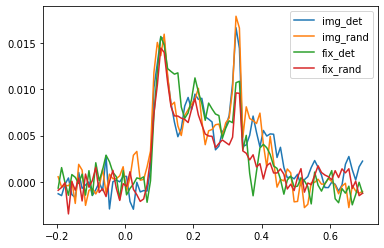

In [11]:
import matplotlib.pyplot as plt
for key in edi_data.keys():
    edi_time = []
    for t in range(n_time):
        edi_time.append(np.mean(upper(edi_data[key][:, :, t])) - np.mean(np.diagonal(edi_data[key][:, :, t])))
    plt.plot(dat["time"], edi_time, label = key)

plt.legend()